# initialization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1vkXUOP4lGvCaARhFOirBgj1VwmkX0VI-'}) # replace the id with id of file you want to access
downloaded.GetContentFile('cleaning_1.xlsx') 

In [ ]:
downloaded = drive.CreateFile({'id':'1uWVz1y4tu3UTi7UXAEM1D4cy2KJpdUw8'}) # replace the id with id of file you want to access
downloaded.GetContentFile('stop_words.txt') 

# Preprocessing

# Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
df = pd.read_excel (r'cleaning_1.xlsx')
df.shape

(2285, 3)

In [ ]:
df['intent'].replace(to_replace=[' drug+dose','drug+dose', 'drug+dpse'], value='drugs', inplace=True)
df['intent'].replace(to_replace=['contageos', 'contagious'] ,value ='contageous', inplace=True)
df['intent'].replace(to_replace=['info', 'Info'], value='information', inplace=True)

In [ ]:
indexNames=df[(df['intent'] =='drugs') 
              | (df['intent'] =='food+product') 
              | (df['intent']=='vaccine')
              |(df['intent'] =='symptoms')].index.tolist()

In [ ]:
df=df.iloc[indexNames,:]

In [ ]:
df.intent.unique() , df.shape

(array(['drugs', 'food+product', 'symptoms', 'vaccine'], dtype=object),
 (1984, 3))

In [ ]:
df[df.intent=='food+product'].values

array([['طفلي عمره شهرين و٢٠ يوم استخدم له حليب بليميل بلس كمفورت لكن الطفل دائم المغص هكذا فسرت بكاؤه nهل الحليب مناسب ولا أغيره nوزنه عند الولاده ٣ كيلو الآن ٦ كيلو',
        11, 'food+product'],
       ['ما كمية الحليب الازم تناولها في اليوم لطفل عمره سنة ونصف واريد ان اعرف راي الاطباء بحليب النيدو',
        47, 'food+product'],
       ['هل إعطاء العسل للرضيع اقل من سنه يسبب له ضرر ولماذا', 68,
        'food+product'],
       ['هل شرب البابونج للأطفال العمر سنة له أضرار جانبية', 69,
        'food+product'],
       ['orex 250 هل يعالج انفلنزا و سعال للاطفال', 77, 'food+product'],
       ['vلدي طفلة عمرها4شهور ترضع رضاعه طبيعية ولكن حليبي كميته قليلة ولايشبعها وحاولت من البداية ان اعطيها حليب صناعي ولكنها ترفض الرضاعة رفضا تاما ولاترضى بغير الرضاعه الطبيعه انصحوني ماذا افعل مع العلم من يوم ولادتها وانا اشرب الحلبة وجميع الاشياء التي تدر الحليب لكن كمية الحليب تبقى قليلة',
        79, 'food+product'],
       ['أبني عمره خمس سنوات جسمه ضعيف جدا أكله قليل لايشكو من اي شي ماهي الطريقه او 

# clean data

In [ ]:
# ==== Helper Methods =====
import re
import numpy as np
from nltk import ngrams
import matplotlib.pyplot as plt

# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [ ]:
df['question'] =  df['question'].apply(lambda x: clean_str(x))

# Stop Words

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

from nltk.corpus import stopwords
stopwords_list = stopwords.words('arabic')
#print(stopwords_list)
#---------------------------------------------------------------------------
egyp=[]
# Using readlines()

file1 = open("stop_words.txt", "r" ,encoding = "utf-8")
Lines = file1.readlines()
count = 0
# Strips the newline character
for line in Lines:
    count += 1
    egyp.append(line.strip())
    
    #print( line.strip())
#print(egyp)
#----------------------------------------------------------------------------
# combine two lists
egyp=egyp+stopwords_list

In [ ]:
df['question']=df['question'].apply(lambda words: ' '.join(re.sub('^(ال)',"",word)
                                                           for word in words.split() if ((word not in egyp))))


# Over sampling

In [ ]:
dr=df[df["intent"]=='vaccine']


In [ ]:
df_repeated = pd.concat([df[df["intent"]=='vaccine']]*3, ignore_index=True)  # vaccine 59*4=236
frames = [df_repeated, df]
result = pd.concat(frames)

In [ ]:
X = result['question']
y = result['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

# Naive Bayes classifier for multinomial models

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


#{'clf__alpha': 0.1,
 #'tfidf__norm': 'l2',
 #'tfidf__use_idf': False,
 #'vect__ngram_range': (1, 1)}


X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

nb = Pipeline([('vect', CountVectorizer(max_features=24 )),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha=0.1)),
              ])
nb.fit(X_train, y_train);

In [ ]:
%%time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

# Linear support vector machine

In [ ]:
from sklearn.linear_model import SGDClassifier


X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)


sgd = Pipeline([('vect', CountVectorizer(max_features=24)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier( n_jobs=-1,loss='hinge', penalty='l1',alpha=0.01, random_state=42, max_iter=20, tol=None)),
               ])
sgd.fit(X_train, y_train);

NameError: ignored

In [ ]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

# sgd gridsearch

In [ ]:
pip install parfit

  Created wheel for parfit: filename=parfit-0.220-cp37-none-any.whl size=8661 sha256=fa4790be4295a2fcf75c884050cd8f747fd112b9c8c5cc8d5bf1a1a77095e4f8
  Stored in directory: /root/.cache/pip/wheels/d9/8a/c9/ed86e85ad0cb41ce2fdcb6bc215902dc475bd3fb1fef7c742d
Successfully built parfit


In [ ]:
# from sklearn.model_selection import ParameterGrid
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import roc_auc_score
# import parfit.parfit as pf

# grid = {
#     'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
#     'n_iter': [1000], # number of epochs
#     'loss': ['log'], # logistic regression,
#     'penalty': ['l2'],
#     'n_jobs': [-1]
# }
# paramGrid = ParameterGrid(grid)

# bestModel, bestScore, allModels, allScores = 
# pf.bestFit(SGDClassifier, paramGrid,
#            X_train, y_train, X_val, y_val, 
#            metric = roc_auc_score, bestScore='max',
#            scoreLabel = "AUC")

# print(bestModel, bestScore)

In [ ]:
from sklearn.model_selection import GridSearchCV
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

In [ ]:



parameters={
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
     #'clf__n_iter': [1000], # number of epochs
     'clf__loss': ['log','hinge'], # logistic regression,
     'clf__penalty': ['l2','l1'],
     'clf__n_jobs': [-1,1]
 }
sgd = Pipeline([('vect', CountVectorizer(max_features=24)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier( random_state=42, max_iter=5, tol=None)),
               ])
 


NameError: ignored

In [ ]:
grid_pipeline = GridSearchCV(sgd,parameters , cv=5)
# fit
grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

In [ ]:
df2=pd.DataFrame(grid_pipeline.cv_results_)

# Logistic regression

In [ ]:
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
piplrtf = Pipeline([('vect', CountVectorizer(max_features=380)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=0.3,penalty='l1',solver='liblinear',multi_class='ovr')),
                
               ])
               
piplrtf.fit(X_train, y_train);

In [ ]:

%%time

y_pred = piplrtf.predict(X_test)



#print('accuracy %s' % accuracy_score(y_pred, y_test))

print("normal data LR + countervectorizer c=0.3 , penality = l1 solver=liblinear \n")
print(classification_report(y_test, y_pred))



normal data LR + countervectorizer c=0.3 , penality = l1 solver=liblinear 

              precision    recall  f1-score   support

       drugs       0.78      0.47      0.58       208
food+product       0.67      0.47      0.55        91
    symptoms       0.63      0.89      0.73       279
     vaccine       1.00      0.67      0.80        18

    accuracy                           0.67       596
   macro avg       0.77      0.62      0.67       596
weighted avg       0.70      0.67      0.66       596

CPU times: user 27.4 ms, sys: 0 ns, total: 27.4 ms
Wall time: 27.5 ms


In [ ]:
pickle.dump(piplrtf, open('tfidfبب_reg.pkl', 'wb'))
 
# some time later...
 
# load the model from disk
tfidf_lr = pickle.load(open('tfidfبب_reg.pkl', 'rb'))
q=pd.Series(' ابني اعبان بقاله فتره و عنده كحه و عطس المفروض اديله ايه')
tfidf_lr.predict_proba(q)

#tfidf_lr.predict(q)


array([[0.31503697, 0.0909701 , 0.57542793, 0.018565  ]])

In [ ]:
tfidf_lr.predict(q)

array(['symptoms'], dtype=object)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define model
model = LogisticRegression()
# define the ovr strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X, y)

# learning curve

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'drugs'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'drugs'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the 

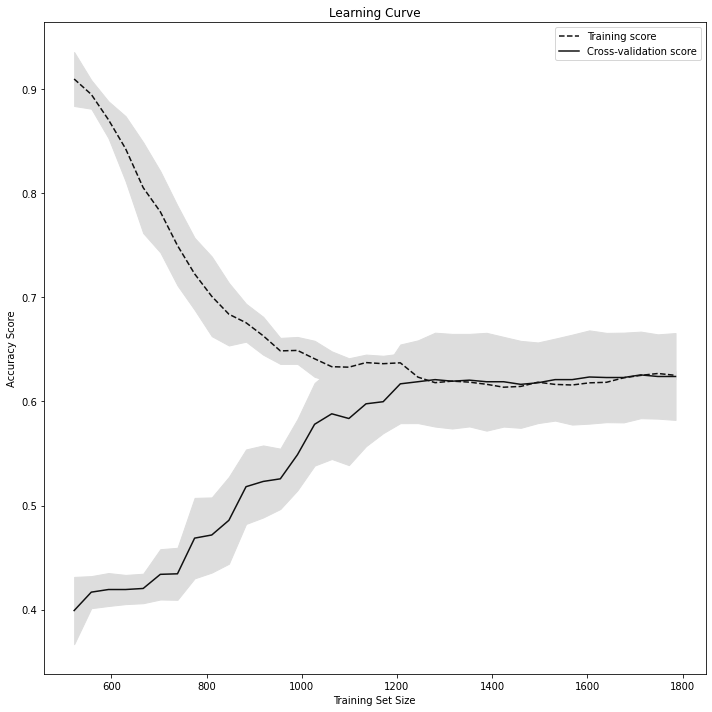

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import learning_curve


X, y = df['question'], df['intent']

MOD=Pipeline([('vect', CountVectorizer(max_features=24)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=0.3,solver='liblinear',penalty='l1')),
               ])

train_sizes, train_scores, test_scores = learning_curve(MOD, X, y, cv=10, scoring='accuracy', n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------------------------

# Doc2vec and Logistic Regression

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re




/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

#X_train, X_test, y_train, y_test = train_test_split(df.question, df.intent, random_state=0, test_size=0.3, stratify=y)

#X_train, X_test, y_train, y_test = train_test_split(df.question, df.intent, random_state=0, test_size=0.3, stratify=y)

X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

In [ ]:

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 100, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 100, 'Test')

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1)
logreg.fit(train_vectors_dbow, y_train)

In [ ]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

# saving and calling

In [ ]:
import pickle


pickle.dump(model_dbow, open('doc2vec', 'wb'))
 
# some time later...
 
# load the model from disk
doc2vecmodel = pickle.load(open('doc2vec', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [ ]:
pickle.dump(logreg, open('LR_doc2vec', 'wb'))
 
# some time later...
 
# load the model from disk
lrmodel = pickle.load(open('LR_doc2vec', 'rb'))

In [ ]:

q=pd.Series('تطعيم')
X_test= label_sentences(q, 'Test')
all_data=X_test

test_vectors_dbow = get_vectors(doc2vecmodel, len(X_test), 100, 'Test')
y_pred = lrmodel.predict(test_vectors_dbow)

y_pred   

array(['symptoms'], dtype=object)

array(['symptoms'], dtype=object)

# regulization

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.learning_curve import validation_curve
from sklearn.model_selection import learning_curve, GridSearchCV


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

#X = df['question']
#y = df['intent']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)



#C_param_range = [0.001,0.01,0.1,1,10,100]

C_param_range = [0.001,0.01,0.1,1,10,100,0.01,0.03,0.3,3,30]


sepal_acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
sepal_acc_table['C_parameter'] = C_param_range

plt.figure(figsize=(10, 10))

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(n_jobs=1, C=i)

    #lr.fit(X_train_sepal_std,y_train_sepal)
    lr.fit(train_vectors_dbow, y_train);
    # Predict using model
    y_pred = lr.predict(test_vectors_dbow)


    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score, confusion_matrix
    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))






    # Saving accuracy score in table
    sepal_acc_table.iloc[j,1] = accuracy_score(y_pred, y_test)
    j += 1
    
sepal_acc_table

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.5192604006163328
              precision    recall  f1-score   support

       drugs       0.55      0.29      0.38       208
food+product       0.00      0.00      0.00        91
    symptoms       0.51      0.99      0.68       279
     vaccine       0.00      0.00      0.00        71

    accuracy                           0.52       649
   macro avg       0.27      0.32      0.26       649
weighted avg       0.40      0.52      0.41       649

accuracy 0.7026194144838213
              precision    recall  f1-score   support

       drugs       0.65      0.62      0.64       208
food+product       0.79      0.33      0.47        91
    symptoms       0.68      0.87      0.76       279
     vaccine       0.98      0.77      0.87        71

    accuracy                           0.70       649
   macro avg       0.78      0.65      0.68       649
weighted avg       0.72      0.70      0.69       649

accuracy 0.7395993836671803
              precision    recall  f1-score   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


accuracy 0.7334360554699538
              precision    recall  f1-score   support

       drugs       0.69      0.63      0.66       208
food+product       0.66      0.55      0.60        91
    symptoms       0.73      0.81      0.77       279
     vaccine       0.91      0.99      0.95        71

    accuracy                           0.73       649
   macro avg       0.75      0.74      0.74       649
weighted avg       0.73      0.73      0.73       649

accuracy 0.7303543913713405
              precision    recall  f1-score   support

       drugs       0.69      0.63      0.66       208
food+product       0.65      0.54      0.59        91
    symptoms       0.73      0.81      0.77       279
     vaccine       0.90      0.97      0.93        71

    accuracy                           0.73       649
   macro avg       0.74      0.74      0.74       649
weighted avg       0.73      0.73      0.73       649

accuracy 0.7026194144838213
              precision    recall  f1-score   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.7349768875192604
              precision    recall  f1-score   support

       drugs       0.68      0.66      0.67       208
food+product       0.73      0.45      0.56        91
    symptoms       0.73      0.84      0.78       279
     vaccine       0.94      0.92      0.93        71

    accuracy                           0.73       649
   macro avg       0.77      0.72      0.73       649
weighted avg       0.74      0.73      0.73       649

accuracy 0.7411402157164869
              precision    recall  f1-score   support

       drugs       0.70      0.65      0.67       208
food+product       0.70      0.55      0.62        91
    symptoms       0.73      0.81      0.77       279
     vaccine       0.91      0.97      0.94        71

    accuracy                           0.74       649
   macro avg       0.76      0.75      0.75       649
weighted avg       0.74      0.74      0.74       649

accuracy 0.7349768875192604
              precision    recall  f1-score   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,C_parameter,Accuracy
0,0.001,0.51926
1,0.010,0.702619
2,0.100,0.739599
3,1.000,0.736518
4,10.000,0.733436
5,100.000,0.730354
6,0.010,0.702619
7,0.030,0.734977
8,0.300,0.74114
9,3.000,0.734977


<Figure size 720x720 with 0 Axes>

# REGULI

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.learning_curve import validation_curve
from sklearn.model_selection import learning_curve, GridSearchCV


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)



#C_param_range = [0.001,0.01,0.1,1,10,100]

#C_param_range = [0.001,0.01,0.1,1,10,100,0.01,0.03,0.3,3,30]

C_param_range =[0.01,0.03,0.1,0.3,1,3,10,30,100]

sepal_acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
sepal_acc_table['C_parameter'] = C_param_range

plt.figure(figsize=(10, 10))

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = Pipeline([('vect', CountVectorizer(max_features=24)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=i ,penalty='l1',solver='liblinear')),
               ])
    #lr.fit(X_train_sepal_std,y_train_sepal)
    lr.fit(X_train, y_train);
    # Predict using model
    y_pred = lr.predict(X_test)

    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score, confusion_matrix
    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))





    # Saving accuracy score in table
    sepal_acc_table.iloc[j,1] = accuracy_score(y_test,y_pred)
    j += 1
    
sepal_acc_table

accuracy 0.46812080536912754
              precision    recall  f1-score   support

       drugs       0.00      0.00      0.00       208
food+product       0.00      0.00      0.00        91
    symptoms       0.47      1.00      0.64       279
     vaccine       0.00      0.00      0.00        18

    accuracy                           0.47       596
   macro avg       0.12      0.25      0.16       596
weighted avg       0.22      0.47      0.30       596

accuracy 0.5251677852348994
              precision    recall  f1-score   support

       drugs       0.88      0.07      0.12       208
food+product       0.81      0.27      0.41        91
    symptoms       0.50      0.98      0.66       279
     vaccine       0.00      0.00      0.00        18

    accuracy                           0.53       596
   macro avg       0.55      0.33      0.30       596
weighted avg       0.66      0.53      0.42       596

accuracy 0.6208053691275168
              precision    recall  f1-score  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.6359060402684564
              precision    recall  f1-score   support

       drugs       0.76      0.47      0.58       208
food+product       0.69      0.48      0.57        91
    symptoms       0.59      0.85      0.70       279
     vaccine       0.00      0.00      0.00        18

    accuracy                           0.64       596
   macro avg       0.51      0.45      0.46       596
weighted avg       0.65      0.64      0.61       596

accuracy 0.6375838926174496
              precision    recall  f1-score   support

       drugs       0.72      0.48      0.58       208
food+product       0.70      0.49      0.58        91
    symptoms       0.60      0.84      0.70       279
     vaccine       0.00      0.00      0.00        18

    accuracy                           0.64       596
   macro avg       0.51      0.45      0.46       596
weighted avg       0.64      0.64      0.62       596

accuracy 0.6442953020134228
              precision    recall  f1-score   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.6442953020134228
              precision    recall  f1-score   support

       drugs       0.72      0.50      0.59       208
food+product       0.69      0.52      0.59        91
    symptoms       0.61      0.84      0.70       279
     vaccine       0.00      0.00      0.00        18

    accuracy                           0.64       596
   macro avg       0.50      0.46      0.47       596
weighted avg       0.64      0.64      0.63       596

accuracy 0.6426174496644296
              precision    recall  f1-score   support

       drugs       0.72      0.50      0.59       208
food+product       0.69      0.52      0.59        91
    symptoms       0.61      0.84      0.70       279
     vaccine       0.00      0.00      0.00        18

    accuracy                           0.64       596
   macro avg       0.50      0.46      0.47       596
weighted avg       0.64      0.64      0.62       596

accuracy 0.6409395973154363
              precision    recall  f1-score   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,C_parameter,Accuracy
0,0.01,0.468121
1,0.03,0.525168
2,0.10,0.620805
3,0.30,0.635906
4,1.00,0.637584
5,3.00,0.644295
6,10.00,0.644295
7,30.00,0.642617
8,100.00,0.64094


<Figure size 720x720 with 0 Axes>

# pipline grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

In [ ]:
pip= Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1)),
               ])
 
parameters={'vect__max_features':[24],
        'clf__C':[0.01,0.03,0.1,0.3,1,3,10,30,100],
        'tfidf__use_idf': (True, False),
        'clf__penalty':['l1','l2','none'],
        
        'clf__solver':["liblinear",'auto']
        }

In [ ]:
grid_pipeline = GridSearchCV(pip,parameters , cv=5)
# fit
grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got auto.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got auto.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg

{'clf__C': 0.3,
 'clf__penalty': 'l1',
 'clf__solver': 'liblinear',
 'tfidf__use_idf': False,
 'vect__max_features': 24}

In [ ]:
grid_pipeline.cv_results_;

In [ ]:
df2=pd.DataFrame(grid_pipeline.cv_results_)
#df2

In [ ]:
x=df2[[	'param_clf__C','mean_test_score'	]]
x.head(60)

,param_clf__C,mean_test_score
0,0.01,0.429895
1,0.01,0.429895
2,0.03,0.474205
3,0.03,0.476845
4,0.1,0.641564
5,0.1,0.640902
6,0.3,0.646202
7,0.3,0.645542
8,1,0.644874
9,1,0.643549


In [ ]:
#x.tail(70)

In [ ]:
grid_pipeline.best_params_

{'clf__C': 0.3,
 'clf__penalty': 'l1',
 'clf__solver': 'liblinear',
 'tfidf__use_idf': False,
 'vect__max_features': 24}

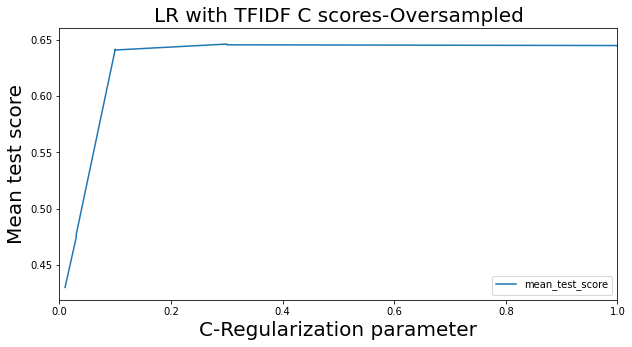

In [ ]:
x['mean_test_score'].values

ax1=x.plot(x='param_clf__C',y='mean_test_score',figsize=((10,5)));
ax1.set_xlim(0,1);

plt.xlabel('C-Regularization parameter',fontsize=20); 
plt.ylabel('Mean test score',fontsize=20); 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)   
# displaying the title
plt.title("LR with TFIDF C scores-Oversampled",fontsize=20);


# naive baiyes tuning

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV


X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2,0.3]
}

In [ ]:
grid_pipeline = GridSearchCV(text_clf,parameters , cv=5)
# fit
grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

{'clf__alpha': 0.1,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 1)}

In [ ]:
df22=pd.DataFrame(grid_pipeline.cv_results_)
df22

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_tfidf__norm,param_tfidf__use_idf,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038833,0.003118,0.007129,0.000101,1,l1,True,"(1, 1)","{'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf_...",0.492806,0.492806,0.503597,0.509025,0.483755,0.496398,0.008910,44
1,0.114513,0.006942,0.012419,0.000588,1,l1,True,"(1, 2)","{'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf_...",0.471223,0.471223,0.467626,0.469314,0.469314,0.469740,0.001359,47
2,0.074124,0.005537,0.008700,0.000308,1,l1,True,"(2, 2)","{'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf_...",0.464029,0.467626,0.467626,0.469314,0.476534,0.469026,0.004132,48
3,0.035565,0.000730,0.006487,0.000185,1,l1,False,"(1, 1)","{'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf_...",0.507194,0.500000,0.525180,0.523466,0.490975,0.509363,0.013263,40
4,0.104171,0.003678,0.011539,0.000471,1,l1,False,"(1, 2)","{'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf_...",0.482014,0.485612,0.478417,0.480144,0.472924,0.479822,0.004195,45
5,0.073064,0.002457,0.008501,0.000740,1,l1,False,"(2, 2)","{'clf__alpha': 1, 'tfidf__norm': 'l1', 'tfidf_...",0.464029,0.471223,0.467626,0.472924,0.480144,0.471189,0.005425,46
6,0.038061,0.002344,0.007053,0.000082,1,l2,True,"(1, 1)","{'clf__alpha': 1, 'tfidf__norm': 'l2', 'tfidf_...",0.654676,0.669065,0.679856,0.653430,0.653430,0.662091,0.010670,16
7,0.104485,0.006400,0.011956,0.000256,1,l2,True,"(1, 2)","{'clf__alpha': 1, 'tfidf__norm': 'l2', 'tfidf_...",0.625899,0.643885,0.661871,0.649819,0.638989,0.644093,0.011882,20
8,0.066979,0.001957,0.008509,0.000275,1,l2,True,"(2, 2)","{'clf__alpha': 1, 'tfidf__norm': 'l2', 'tfidf_...",0.517986,0.503597,0.561151,0.555957,0.552347,0.538207,0.023014,36
9,0.035624,0.001957,0.006353,0.000104,1,l2,False,"(1, 1)","{'clf__alpha': 1, 'tfidf__norm': 'l2', 'tfidf_...",0.654676,0.651079,0.672662,0.657040,0.671480,0.661387,0.008935,17


# Draft(Ignore)

In [1]:
# from tqdm import tqdm
# tqdm.pandas(desc="progress-bar")
# from gensim.models import Doc2Vec
# from sklearn import utils
# import gensim
# from gensim.models.doc2vec import TaggedDocument
# import re



# def label_sentences(corpus, label_type):
#     """
#     Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
#     We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
#     a dummy index of the post.
#     """
#     labeled = []
#     for i, v in enumerate(corpus):
#         label = label_type + '_' + str(i)
#         labeled.append(TaggedDocument(v.split(), [label]))
#     return labeled



# #------------------------------------------------------------------------
# def get_vectors(model, corpus_size, vectors_size, vectors_type):
#   """
#   Get vectors from trained doc2vec model
#   :param doc2vec_model: Trained Doc2Vec model
#   :param corpus_size: Size of the data
#   :param vectors_size: Size of the embedding vectors
#   :param vectors_type: Training or Testing vectors
#   :return: list of vectors
#   """
#   vectors = np.zeros((corpus_size, vectors_size))
#   for i in range(0, corpus_size):
#       prefix = vectors_type + '_' + str(i)
#       vectors[i] = model.docvecs[prefix]
#   return vectors

In [2]:
# X = df['question']
# y = df['intent']

# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0025, random_state = 42,stratify=y)
# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

# X_train = label_sentences(X_train, 'Train')
# X_test = label_sentences(X_test, 'Test')
# all_data = X_train + X_test

# #-----------------------------------------------------------------------------------------------
# model_dbow = Doc2Vec(dm=0, vector_size=24, negative=5, min_count=3, alpha=0.065, min_alpha=0.065)



# reg=10
# ep=20


# #model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
#                                  # dm_mean=1, # dm = 1 for using mean of the context word vectors
#                                  # size=200, # no. of desired features
#                                  # window=5, # width of the context window
#                                  # negative=7, # if > 0 then negative sampling will be used
#                                   #min_count=5, # Ignores all words with total frequency lower than 2.
#                                  # workers=3, # no. of cores
#                                  # alpha=0.1, # learning rate
#                                  # seed = 23)



# # model_dbow = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
# #                                   dm_mean=1, # dm = 1 for using mean of the context word vectors
# #                                   size=25, # no. of desired features
# #                                   window=5, # width of the context window
# #                                   negative=7, # if > 0 then negative sampling will be used
# #                                   min_count=5, # Ignores all words with total frequency lower than 2.
# #                                   workers=3, # no. of cores
# #                                   alpha=0.1, # learning rate
# #                                   seed = 23)

# model_dbow.build_vocab([x for x in tqdm(all_data)])
# #--------------------------------------------------------------------------------------
# for epoch in range(ep):
#     model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
#     model_dbow.alpha -= 0.002
#     model_dbow.min_alpha = model_dbow.alpha   

# #--------------------------------------------------------------------------------------------------- 
# train_vectors_dbow = get_vectors(model_dbow, len(X_train), 24, 'Train')
# test_vectors_dbow = get_vectors(model_dbow, len(X_test), 24, 'Test')
# #---------------------------------------------------------------------------

# #-------------------------------------------------
# #---------------------------------------------------

# # parameters={
# #         'clf__C':[0.01,0.03,0.1,0.3,1,3,10,30,100],
      
# #         'clf__penalty':['l1','l2','none'],
        
# #         'clf__solver':["liblinear",'auto']
# #         }

# # logreg= Pipeline([
# #                 ('clf', LogisticRegression(n_jobs=1)),
# #                ])       


# # grid_pipeline = GridSearchCV(logreg,parameters , cv=5)
# # # fit
# # grid_pipeline.fit(train_vectors_dbow, y_train)
# # grid_pipeline.best_params_
# #------------------------------------------------------------------------
# logreg = LogisticRegression(n_jobs=1, C=reg , solver='liblinear',penalty='l1')
# logreg.fit(train_vectors_dbow, y_train)
# #-----------------------------------------------------------------------------

# logreg = logreg.fit(train_vectors_dbow, y_train)
# y_pred = logreg.predict(test_vectors_dbow)
# #-----------------------------------------------------

# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score, confusion_matrix
# print('accuracy %s' % accuracy_score(y_pred, y_test))


# print(" doc2vec"+" [ C="+str(reg)+" epoch="+str(ep)+" ]")
# print(classification_report(y_test, y_pred))



In [3]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
# from sklearn import datasets
# from sklearn.model_selection import learning_curve








# #X, y = df['question'], df['intent']

# MOD=Pipeline([
#                 ('clf', LogisticRegression(n_jobs=1,C=reg,solver='liblinear',penalty='l1')),
#              ]) 

# train_sizes, train_scores, test_scores = learning_curve(MOD, train_vectors_dbow, y_train, cv=10, scoring='accuracy', n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 50),)

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)

# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.subplots(1, figsize=(10,10))
# plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
# plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# plt.title("Learning Curve [ C="+str(reg)+" epoch="+str(ep)+" ]")
# plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
# plt.tight_layout()
# plt.show()
